STAT 453: Deep Learning (Spring 2021)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

---

# Deep Convolutional GAN Trained on CelebA

## Imports

In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt

c:\Users\ammar\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\ammar\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\ammar\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


#### Import utility functions

In [2]:
from helper_data import get_dataloaders_celeba
from helper_train import train_gan_v1, train_wgan_v1
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_multiple_training_losses
from helper_plotting import plot_generated_images

In [3]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 42
GENERATOR_LEARNING_RATE = 0.0002
DISCRIMINATOR_LEARNING_RATE = 0.0002

NUM_EPOCHS = 200
BATCH_SIZE = 128

IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 128, 128, 3

Device: cuda:0


In [4]:
set_deterministic
set_all_seeds(RANDOM_SEED)

## Dataset

In [5]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import numpy as np
import torch
import math
import os
import glob

class_names = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H',
    8: 'I'
}

transform = transforms.Compose([
            # transforms.RandomHorizontalFlip(), # Flip the data horizontally
            transforms.ToPILImage(),
            transforms.Resize((128, 128)),
            # transforms.RandomAdjustSharpness(0.25),
            transforms.RandomHorizontalFlip(0.5),
            # transforms.RandomVerticalFlip(0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        ])

# Load the data with all of the classes
root = '..\\data\\'
data_dirs = glob.glob(root + '**/*.jpg', recursive=True)
data_dirs = np.array(data_dirs)
data_dirs = data_dirs.flatten()

roots = np.array([root] * len(data_dirs))
data_dirs = np.core.defchararray.add(roots, data_dirs)


# data_list = np.array(data.imgs)

# Get the indices for the train/val/test split of 75/15/15
train_split = math.floor(0.99 * len(data_dirs))
val_split = math.ceil(0.01 * len(data_dirs))
test_split = val_split * 0

# print(train_split + val_split + test_split, len(data_arr))

# Make sure the splits are correct
assert train_split + val_split + test_split == len(data_dirs)

# Split the dataset randomely
generator = torch.Generator().manual_seed(1)
train, val, test = torch.utils.data.random_split(data_dirs, [train_split, val_split, test_split], generator=generator)

len(train), len(val), len(test)

(15131, 153, 0)

In [6]:
import cv2

class GenData(torch.utils.data.Dataset):
    '''
        Data set class to store the feature maps
    
    '''

    def __init__(self, in_data, transform=None):
        # data = np.array(in_data)
        self.input_dirs = in_data
        # self.labels = data[:, 1]
        self.labels = []
        self.input_transform = transform[0]
        self.transform = transform[1]
        self.resize_transform = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize(128)
                                ])


    def __len__(self):
        return len(self.input_dirs)
    
    def __getitem__(self, idx):
        input_dir = self.input_dirs[idx]

        # Load the data
        inputs = cv2.imread(input_dir)
        inputs = cv2.cvtColor(inputs, cv2.COLOR_BGR2RGB)
        # inputs = inputs.swapaxes(0, 2)

        # labels = (int)(self.labels[idx])

        if self.transform:
            inputs = self.input_transform(inputs)
            transformed = self.transform(inputs)

            # labels = self.input_transform(labels)

            return inputs, inputs
        else:
            return inputs, inputs, inputs
        
# Create data loaders
def get_data_loaders(batch_size=1):
    
    train_data = GenData(data_dirs[train.indices], transform=(transform, transform))
    val_data = GenData(data_dirs[val.indices], transform=(transform, transform))
    test_data = GenData(data_dirs[test.indices], transform=(transform, transform))

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

    return train_dataloader, val_dataloader, test_dataloader

In [7]:
##########################
### Dataset
##########################


custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop((160, 160)),
    torchvision.transforms.Resize([IMAGE_HEIGHT, IMAGE_WIDTH]),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_loader, valid_loader, test_loader = get_data_loaders(
    batch_size=BATCH_SIZE)
    # train_transforms=custom_transforms,
    # test_transforms=custom_transforms,
    # num_workers=4)

In [8]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break
    
# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([128, 3, 128, 128])
Image label dimensions: torch.Size([128, 3, 128, 128])

Validation Set:
Image batch dimensions: torch.Size([128, 3, 128, 128])
Image label dimensions: torch.Size([128, 3, 128, 128])

Testing Set:


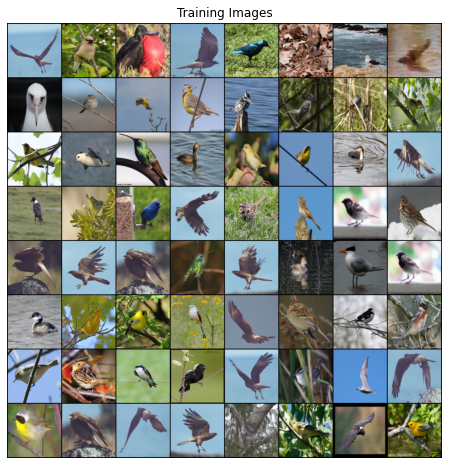

In [9]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:64], 
                                         padding=2, normalize=True),
                        (1, 2, 0)))

## Model

In [10]:
##########################
### MODEL
##########################

class DCGAN(torch.nn.Module):

    def __init__(self, latent_dim=100, 
                 num_feat_maps_gen=64, num_feat_maps_dis=64,
                 color_channels=3):
        super().__init__()
        
        
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, num_feat_maps_gen*8, 
                               kernel_size=4, stride=1, padding=0,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*8),
            nn.LeakyReLU(inplace=True),
            #
            # size if latent_dim=100: num_feat_maps_gen*8 x 4 x 4
            #
            nn.ConvTranspose2d(num_feat_maps_gen*8, num_feat_maps_gen*4, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*4),
            nn.LeakyReLU(inplace=True),
            #
            # size if latent_dim=100: num_feat_maps_gen*4 x 8 x 8
            #
            nn.ConvTranspose2d(num_feat_maps_gen*4, num_feat_maps_gen*2, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*2),
            nn.LeakyReLU(inplace=True),
            #
            # size if latent_dim=100: num_feat_maps_gen*2 x 16 x 16
            #
            nn.ConvTranspose2d(num_feat_maps_gen*2, num_feat_maps_gen, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen),
            nn.LeakyReLU(inplace=True),
            #
            # size if latent_dim=100: num_feat_maps_gen x 32 x 32
            #
            nn.ConvTranspose2d(num_feat_maps_gen, color_channels, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            #
            # size: color_channels x 64 x 64
            #  
            nn.Tanh()
        )
        
        self.discriminator = nn.Sequential(
            #
            # input size color_channels x image_height x image_width
            #
            nn.Conv2d(color_channels, num_feat_maps_dis,
                      kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(inplace=True),
            #
            # size: num_feat_maps_dis x 32 x 32
            #              
            nn.Conv2d(num_feat_maps_dis, num_feat_maps_dis*2,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),        
            nn.BatchNorm2d(num_feat_maps_dis*2),
            nn.LeakyReLU(inplace=True),
            #
            # size: num_feat_maps_dis*2 x 16 x 16
            #   
            nn.Conv2d(num_feat_maps_dis*2, num_feat_maps_dis*4,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),        
            nn.BatchNorm2d(num_feat_maps_dis*4),
            nn.LeakyReLU(inplace=True),
            #
            # size: num_feat_maps_dis*4 x 8 x 8
            #   
            nn.Conv2d(num_feat_maps_dis*4, num_feat_maps_dis*8,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),        
            nn.BatchNorm2d(num_feat_maps_dis*8),
            nn.LeakyReLU(inplace=True),
            #
            # size: num_feat_maps_dis*8 x 4 x 4
            #   
            nn.Conv2d(num_feat_maps_dis*8, 1,
                      kernel_size=4, stride=1, padding=0),
            
            # size: 1 x 1 x 1
            nn.Flatten(),
            
        )

            
    def generator_forward(self, z):
        img = self.generator(z)
        return img
    
    def discriminator_forward(self, img):
        logits = model.discriminator(img)
        return logits

In [11]:
##########################
### MODEL
##########################

class DCGANLarge(torch.nn.Module):

    def __init__(self, latent_dim=128, 
                 num_feat_maps_gen=64, num_feat_maps_dis=64,
                 color_channels=3):
        super().__init__()
        
        
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, num_feat_maps_gen*8, 
                               kernel_size=4, stride=1, padding=0,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*8),
            nn.LeakyReLU(inplace=True),
            #
            # size if latent_dim=100: num_feat_maps_gen*8 x 4 x 4
            #
            nn.ConvTranspose2d(num_feat_maps_gen*8, num_feat_maps_gen*4, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*4),
            nn.LeakyReLU(inplace=True),
            #
            # size if latent_dim=100: num_feat_maps_gen*4 x 8 x 8
            #
            nn.ConvTranspose2d(num_feat_maps_gen*4, num_feat_maps_gen*4, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*4),
            nn.LeakyReLU(inplace=True),
            #
            # size if latent_dim=100: num_feat_maps_gen*4 x 16 x 16
            #
            nn.ConvTranspose2d(num_feat_maps_gen*4, num_feat_maps_gen*2, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*2),
            nn.LeakyReLU(inplace=True),
            #
            # size if latent_dim=100: num_feat_maps_gen x 32 x 32
            #
            nn.ConvTranspose2d(num_feat_maps_gen*2, num_feat_maps_gen, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen),
            nn.LeakyReLU(inplace=True),
            #
            # size: color_channels x 64 x 64
            # 
            nn.ConvTranspose2d(num_feat_maps_gen, color_channels, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            #
            # size: color_channels x 128 x 128
            #  
            nn.Tanh()
        )
        
        self.discriminator = nn.Sequential(
            #
            # input size color_channels x image_height x image_width
            #
            nn.Conv2d(color_channels, num_feat_maps_dis,
                      kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(inplace=True),
            #
            # size: num_feat_maps_dis x 64 x 64
            #  
            nn.Conv2d(num_feat_maps_dis, num_feat_maps_dis,
                      kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_feat_maps_dis),
            nn.LeakyReLU(inplace=True),
            #
            # size: num_feat_maps_dis x 32 x 32
            #              
            nn.Conv2d(num_feat_maps_dis, num_feat_maps_dis*2,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),        
            nn.BatchNorm2d(num_feat_maps_dis*2),
            nn.LeakyReLU(inplace=True),
            #
            # size: num_feat_maps_dis*2 x 16 x 16
            #   
            nn.Conv2d(num_feat_maps_dis*2, num_feat_maps_dis*4,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),        
            nn.BatchNorm2d(num_feat_maps_dis*4),
            nn.LeakyReLU(inplace=True),
            #
            # size: num_feat_maps_dis*4 x 8 x 8
            #   
            nn.Conv2d(num_feat_maps_dis*4, num_feat_maps_dis*8,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),        
            nn.BatchNorm2d(num_feat_maps_dis*8),
            nn.LeakyReLU(inplace=True),
            #
            # size: num_feat_maps_dis*8 x 4 x 4
            #   
            nn.Conv2d(num_feat_maps_dis*8, 1,
                      kernel_size=4, stride=1, padding=0),
            
            # size: 1 x 1 x 1
            nn.Flatten(),
            
        )

            
    def generator_forward(self, z):
        img = self.generator(z)
        return img
    
    def discriminator_forward(self, img):
        logits = model.discriminator(img)
        return logits

In [12]:
set_all_seeds(RANDOM_SEED)

model = DCGANLarge()
model.to(DEVICE)


optim_gen = torch.optim.Adam(model.generator.parameters(),
                             betas=(0.5, 0.999),
                             lr=GENERATOR_LEARNING_RATE)

optim_discr = torch.optim.Adam(model.discriminator.parameters(),
                               betas=(0.5, 0.999),
                               lr=DISCRIMINATOR_LEARNING_RATE)

## Training

In [ ]:
log_dict = train_gan_v1(num_epochs=NUM_EPOCHS, model=model, 
                        optimizer_gen=optim_gen,
                        optimizer_discr=optim_discr,
                        latent_dim=128,
                        device=DEVICE, 
                        train_loader=train_loader,
                        logging_interval=100,
                        save_model='gan_celeba_big_128.pt')

In [ ]:
state = torch.load('wgan_128.pt')
model.load_state_dict(state)
model = model.to('cuda')

Epoch: 001/200 | Batch 000/119 | Gen/Dis Loss: -0.1027/11.9330
Epoch: 001/200 | Batch 100/119 | Gen/Dis Loss: 21.5169/-5.4011
Saving fig...
Time elapsed: 2.27 min
Epoch: 002/200 | Batch 000/119 | Gen/Dis Loss: 0.0000/3.3689
Epoch: 002/200 | Batch 100/119 | Gen/Dis Loss: 20.9129/-3.8688
Time elapsed: 4.56 min
Epoch: 003/200 | Batch 000/119 | Gen/Dis Loss: 24.1494/-5.2142
Epoch: 003/200 | Batch 100/119 | Gen/Dis Loss: 0.0000/-3.9504
Time elapsed: 6.80 min
Epoch: 004/200 | Batch 000/119 | Gen/Dis Loss: 26.5992/-4.2507
Epoch: 004/200 | Batch 100/119 | Gen/Dis Loss: 36.0261/-4.1792
Time elapsed: 9.07 min
Epoch: 005/200 | Batch 000/119 | Gen/Dis Loss: 0.0000/-4.9742
Epoch: 005/200 | Batch 100/119 | Gen/Dis Loss: 35.0754/-5.3987
Time elapsed: 11.32 min
Epoch: 006/200 | Batch 000/119 | Gen/Dis Loss: 36.3498/-4.9683
Epoch: 006/200 | Batch 100/119 | Gen/Dis Loss: 0.0000/-4.5998
Saving fig...
Time elapsed: 13.57 min
Epoch: 007/200 | Batch 000/119 | Gen/Dis Loss: 24.9197/-4.5292
Epoch: 007/200 | B

c:\Users\ammar\Documents\Year2\aps360\APS360\DCGAN\helper_train.py:617: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 8))


Time elapsed: 228.26 min
Epoch: 102/200 | Batch 000/119 | Gen/Dis Loss: 65.0247/0.2474
Epoch: 102/200 | Batch 100/119 | Gen/Dis Loss: 0.0000/-0.1832
Time elapsed: 230.23 min
Epoch: 103/200 | Batch 000/119 | Gen/Dis Loss: 66.4210/0.1280
Epoch: 103/200 | Batch 100/119 | Gen/Dis Loss: 71.6268/-0.1069
Time elapsed: 232.20 min
Epoch: 104/200 | Batch 000/119 | Gen/Dis Loss: 0.0000/-0.9352
Epoch: 104/200 | Batch 100/119 | Gen/Dis Loss: 70.1313/-0.9564
Time elapsed: 234.15 min
Epoch: 105/200 | Batch 000/119 | Gen/Dis Loss: 68.4480/-0.7788
Epoch: 105/200 | Batch 100/119 | Gen/Dis Loss: 0.0000/0.2839
Time elapsed: 236.13 min
Epoch: 106/200 | Batch 000/119 | Gen/Dis Loss: 65.9540/-0.4104
Epoch: 106/200 | Batch 100/119 | Gen/Dis Loss: 74.6190/0.2022
Saving fig...
Time elapsed: 238.10 min
Epoch: 107/200 | Batch 000/119 | Gen/Dis Loss: 0.0000/-1.3032
Epoch: 107/200 | Batch 100/119 | Gen/Dis Loss: 70.3708/-0.4049
Time elapsed: 240.07 min
Epoch: 108/200 | Batch 000/119 | Gen/Dis Loss: 70.9093/-0.9000


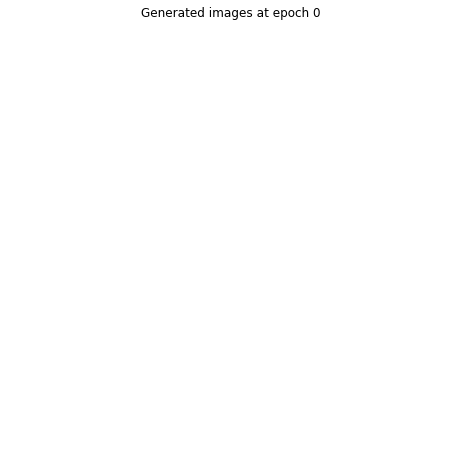

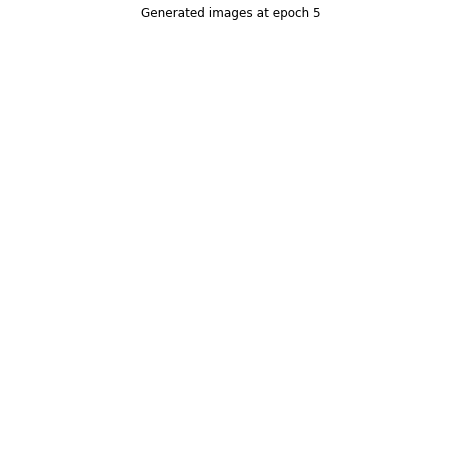

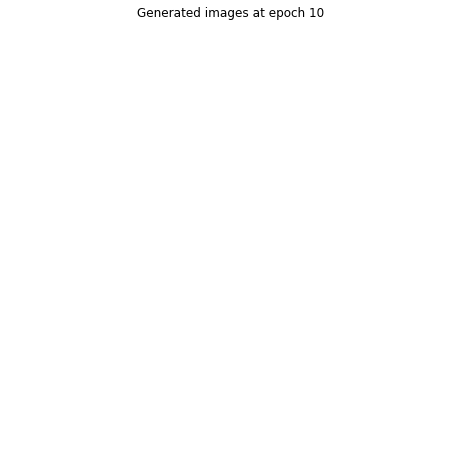

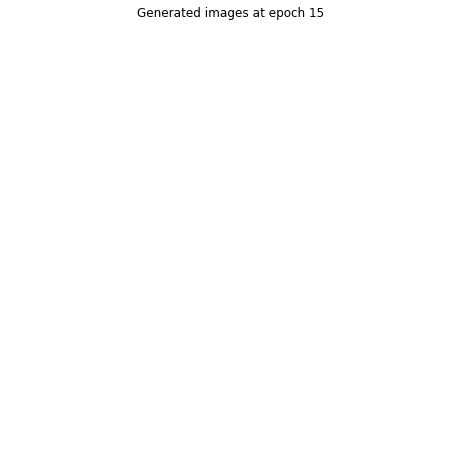

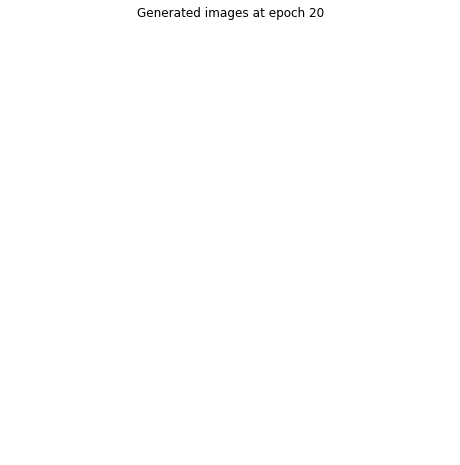

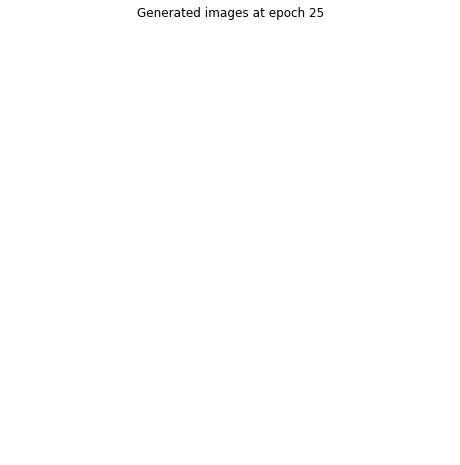

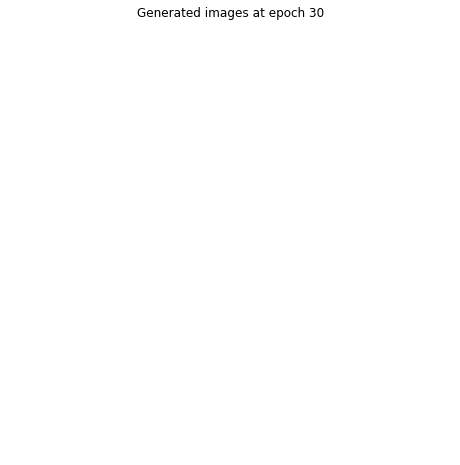

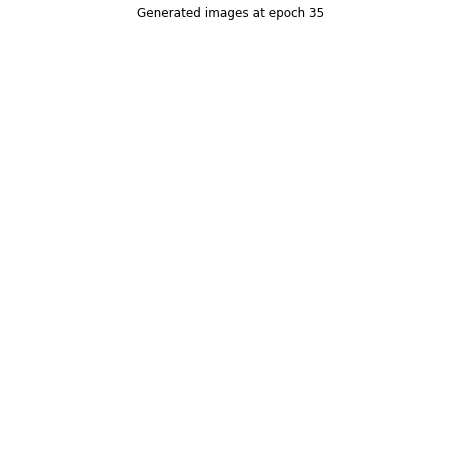

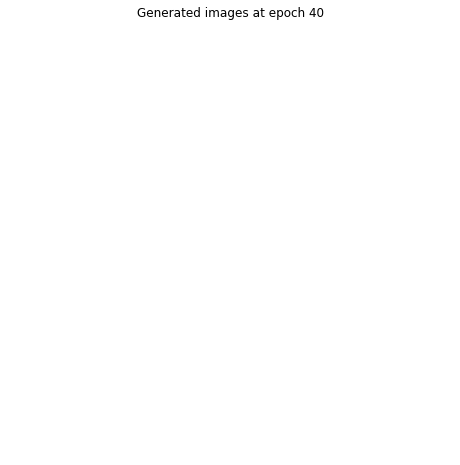

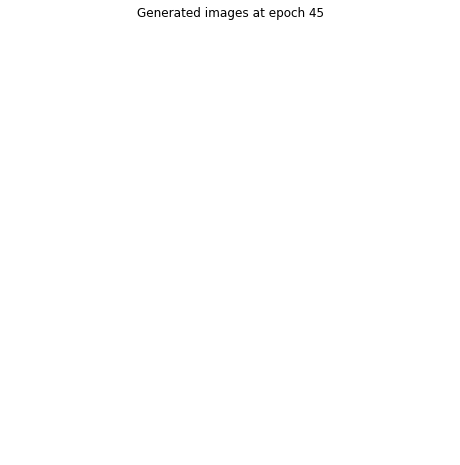

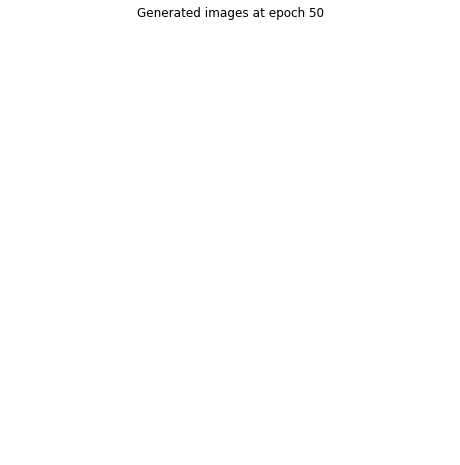

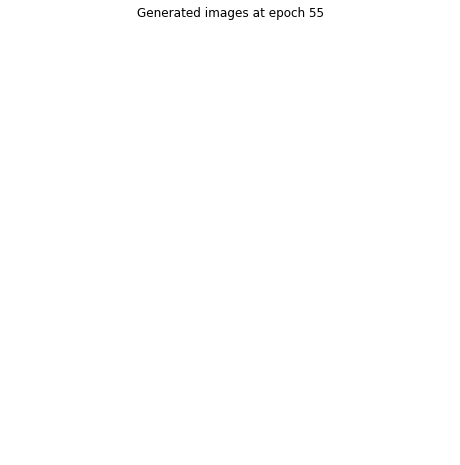

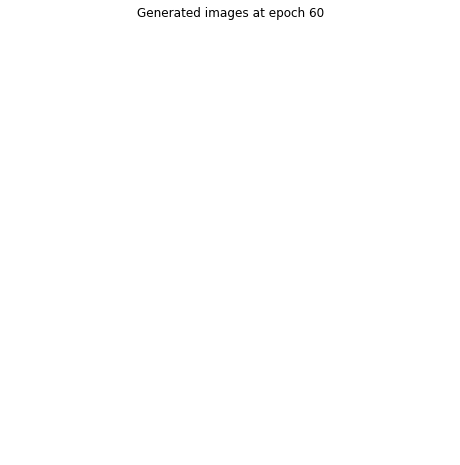

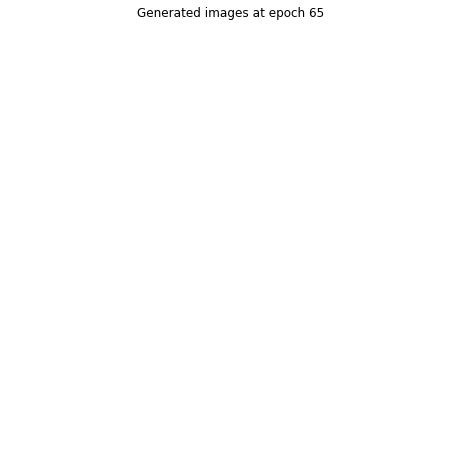

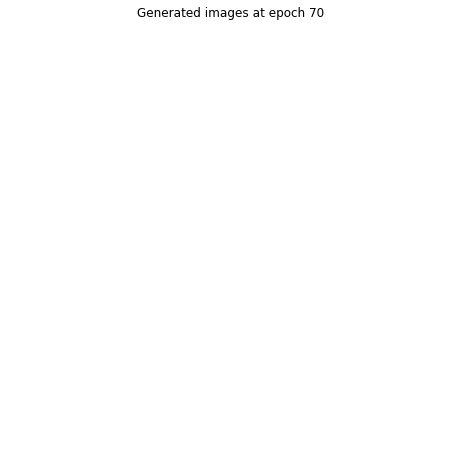

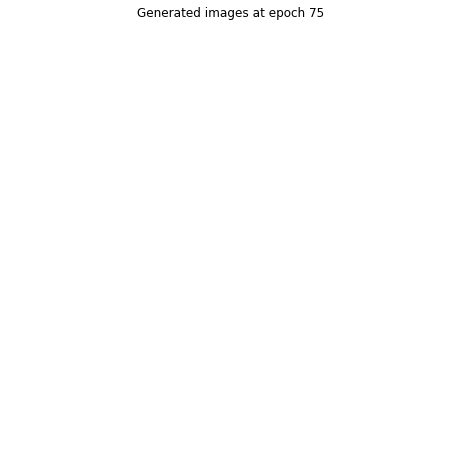

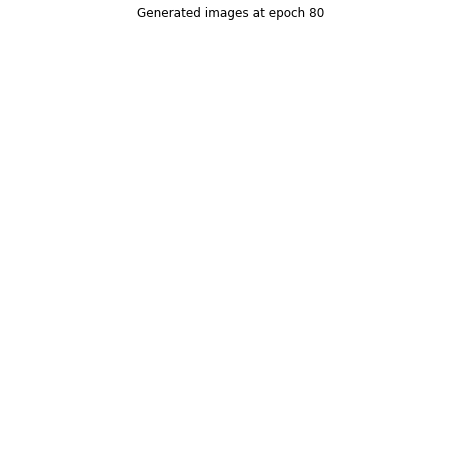

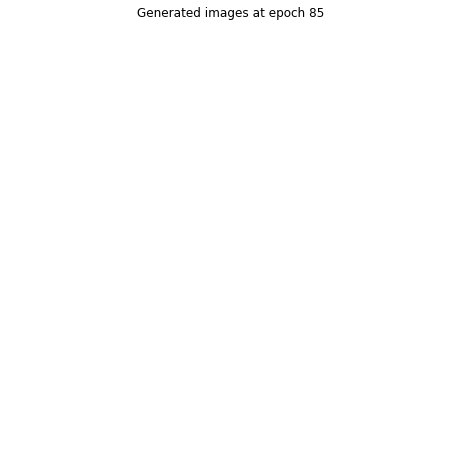

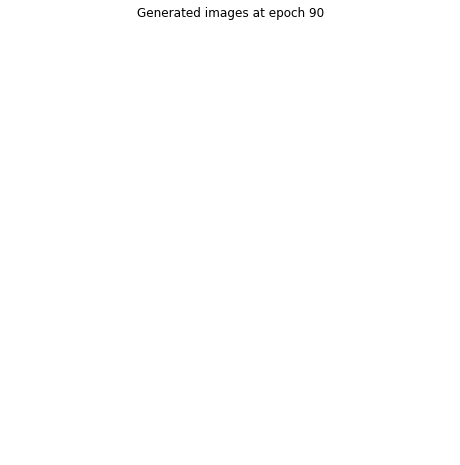

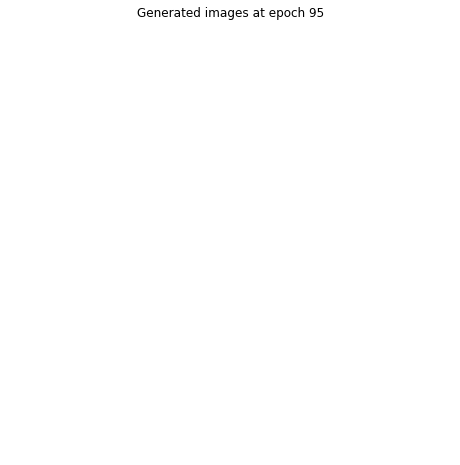

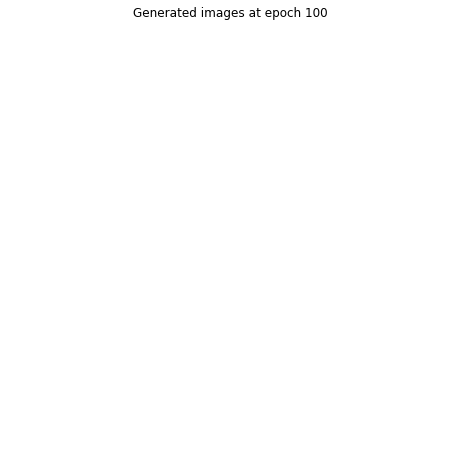

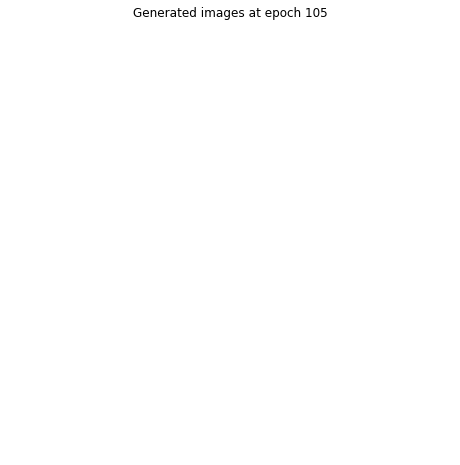

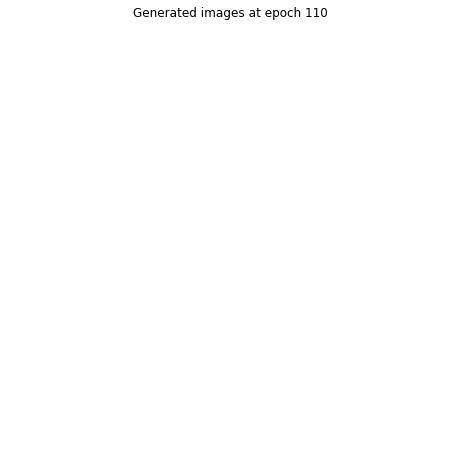

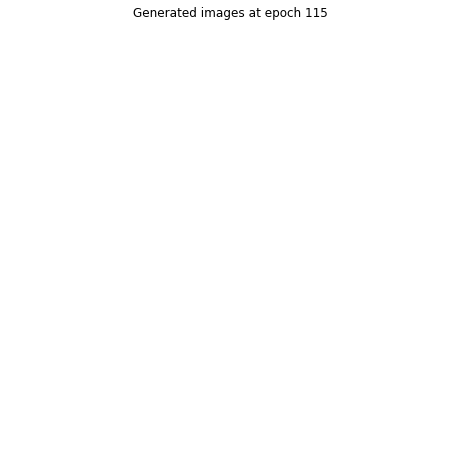

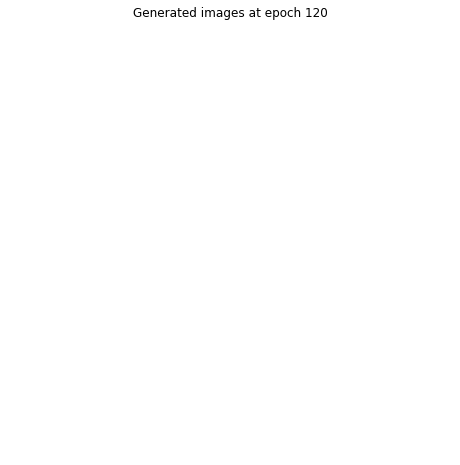

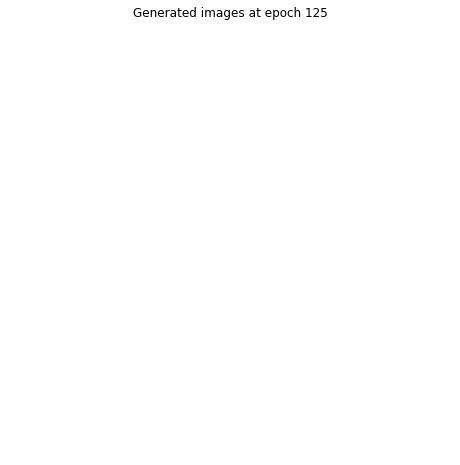

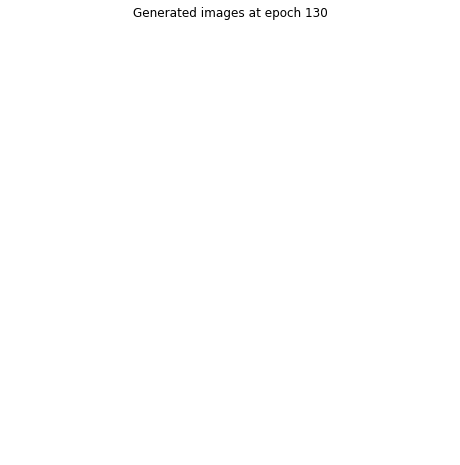

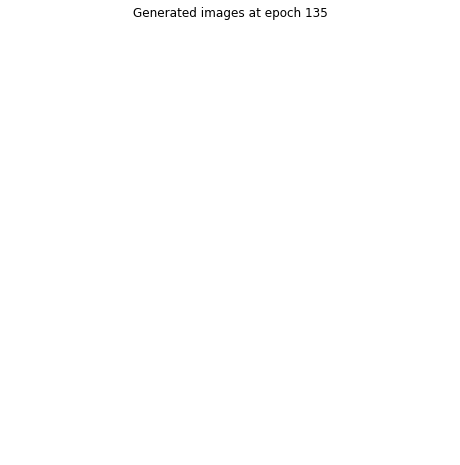

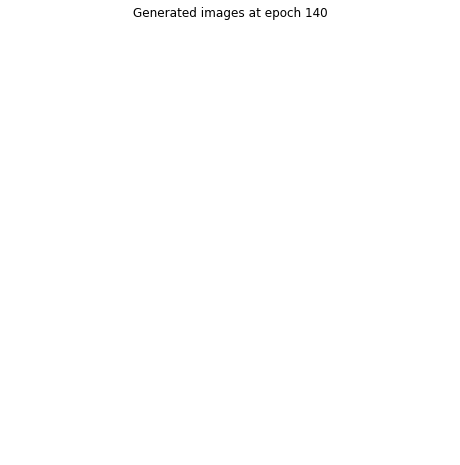

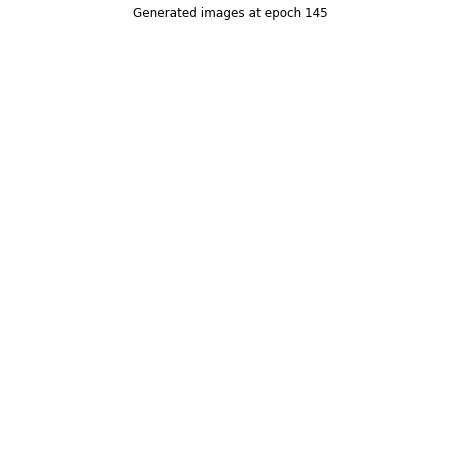

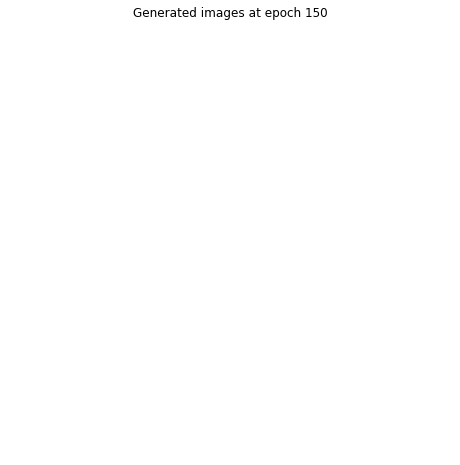

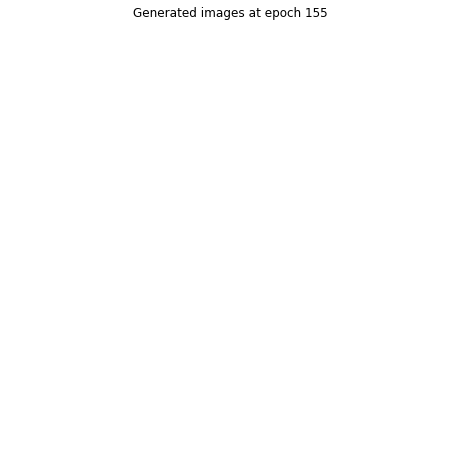

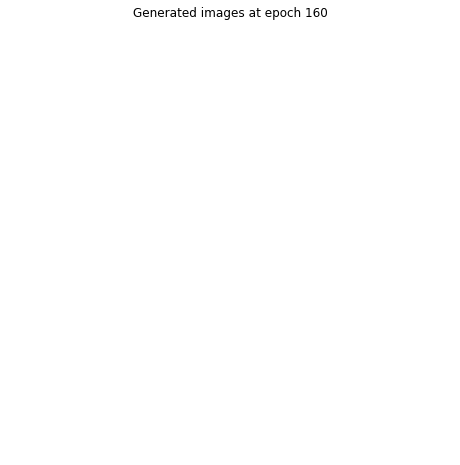

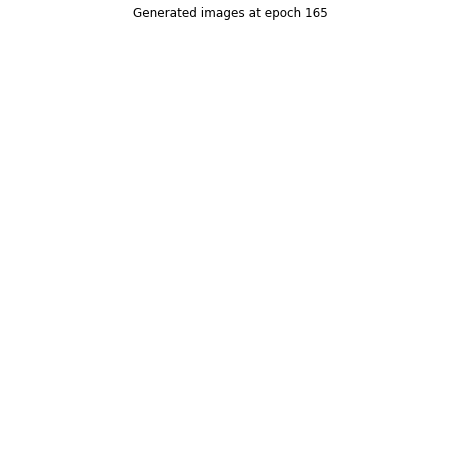

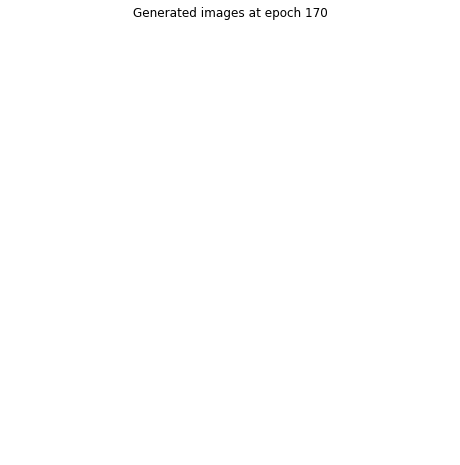

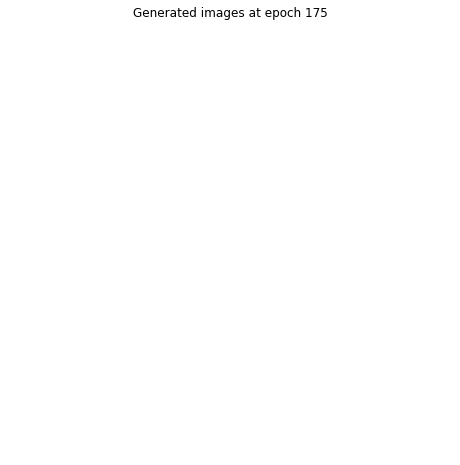

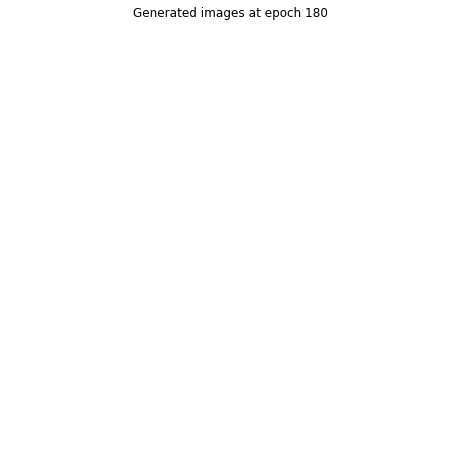

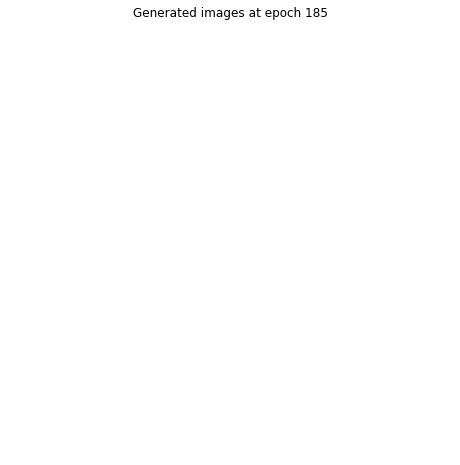

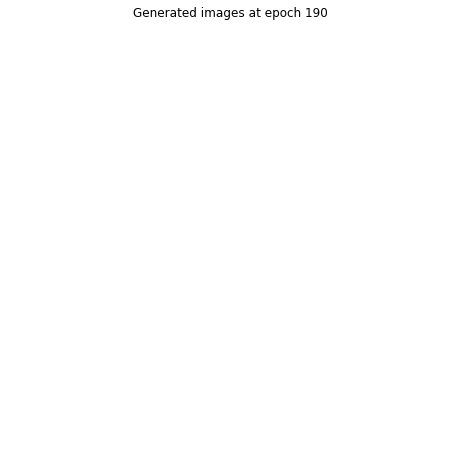

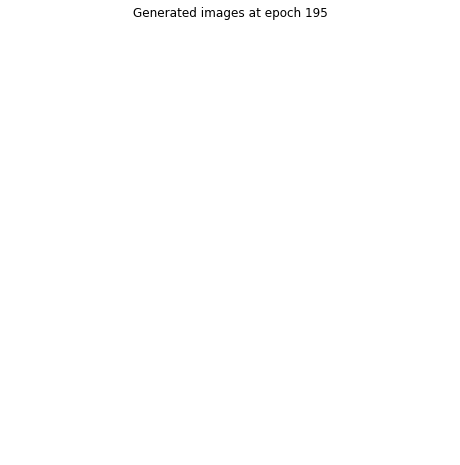

In [13]:
log_dict = train_wgan_v1(num_epochs=NUM_EPOCHS, model=model, 
                        optimizer_gen=optim_gen,
                        optimizer_discr=optim_discr,
                        latent_dim=128,
                        device=DEVICE, 
                        train_loader=train_loader,
                        logging_interval=100,
                        discr_iter_per_generator_iter=2,
                        gradient_penalty=True,
                        save_model='wgan_128_b128.pt')

## Evaluation

In [ ]:
plot_multiple_training_losses(
    losses_list=(log_dict['train_discriminator_loss_per_batch'],
                 log_dict['train_generator_loss_per_batch']),
    num_epochs=NUM_EPOCHS, 
    custom_labels_list=(' -- Discriminator', ' -- Generator')
)

In [ ]:
##########################
### VISUALIZATION
##########################

for i in range(0, NUM_EPOCHS, 10):
    
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.title(f'Generated images at epoch {i}')
    plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][i], (1, 2, 0)))
    plt.show()
    
    
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title(f'Generated images after last epoch')
plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][-1], (1, 2, 0)))
plt.show()

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    print(inp.size())
    inp = inp.detach().cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(16, 16))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
import torch
import random

state_dict = torch.load('wgan_128.pt')
model = DCGANLarge()
model.load_state_dict(state_dict)
model.to('cpu')

vector = torch.randn(128, 128, 1, 1, device='cpu')
vector = vector.to('cpu')
bird = vector[random.randint(0, 128)].unsqueeze(0)
bird2 = vector[random.randint(0, 128)].unsqueeze(0)
birds = []
for i in range(0, 1000, 1):
    birds.append(bird *(1000 - i) / 1000 + bird2 * i / 1000) # 


new = torch.cat(birds, axis=0)
    
output = model.generator_forward(new)
# imshow(torchvision.utils.make_grid(output))

import cv2

def make_animation(arr):
    frames = []
    for inp in arr:
        inp = inp.squeeze().detach().cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)* 255
        inp = cv2.cvtColor(inp.astype(np.uint8), cv2.COLOR_BGR2RGB)
        # cv2.imwrite('test.png', inp)
        frames.append(inp)
    print(len(frames))

    out = cv2.VideoWriter('bird_animation.avi',cv2.VideoWriter_fourcc(*'DIVX'), 200, (128, 128))
 
    for i in range(len(frames)):
        out.write(frames[i])
    out.release()
    
make_animation(output)

In [ ]:
output.size()